# User model in tesnorflow

Author: Krzysztof Rusek, AGH University of Science and Technology

## The model

I assume a simple user models the same as in Lucjan's simulation [Confidence Interval Simulation](https://colab.research.google.com/drive/1h-8hCWy_VWBjBQ2V5Nk5BUWN7g-0ApOp#scrollTo=6qBhGj1PBTq4):
$o_{ij} = \psi_j + \Delta_i + \epsilon_j$

Where $\psi_j \sim U(1-5)$, i.e. it is from uniform distribution. $\Delta_i \sim N(0,b)$, i.e. it is from normal distribution with mean 0 and $b$ is such that the total variance of a single PVS is constant. $\epsilon \sim N(0,a_j)$ so variance is related to PVS but not user, just for simplicity. $a_j$ is driven from Gamma distribution with some parameters. What we know is that the total standard deviation related to specific PVS should be around 0.7-0.8 (Kjell at call at May, 7, 2018). 0.75 will be the mean but distribution makes it possible to have different errors for different cases.

In [0]:
!pip install tensorflow_probability

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import numpy as np
import numpy.random as rn
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [0]:
nPVS = 160 # number of PVSs
nSub = 24 # number of Subjects

std = 0.75 # it is standard deviation for typical PVS
alpha = 30 # it is parameter of the gamma distribution from which the variances are generated 
b = 0.3 # standard deviation for delta distribution

psi = rn.uniform(1,5, size=(nPVS,1)) # MOSs generation
an = rn.gamma(alpha, std/alpha, size=(nPVS,1)) # standard deviations per PVS without delta, it is not used
a = rn.gamma(alpha, np.sqrt(std**2 - b**2)/alpha, size=(nPVS,1)) # std per PVS with delta
Delta = rn.normal(0, b, size=(1,nSub)) # Delta generation 


# Generative model

The code uses Edwart2 probabilistic programming language from [tensorflow_probability](https://github.com/tensorflow/probability) package

In [0]:
g = tf.Graph()
with g.as_default():
    b = tf.Variable(Delta.astype(np.float32))
    c = tf.Variable(psi.astype(np.float32))
    loc = b +c
    #parametryzacja kwadratem gwarantuje dodatnie std
    
    av = tf.Variable(np.sqrt(a).astype(np.float32))**2
    #scale = tf.sqrt(bv + av)
    o = tfp.edward2.Normal(loc=loc,scale=av)
    o = tfp.edward2.QuantizedDistribution(o.distribution, low=1.0, high=5.0)


with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    o_val, = sess.run([o])
    print(o_val)

[[3. 1. 2. ... 2. 2. 1.]
 [3. 3. 4. ... 3. 4. 2.]
 [5. 5. 5. ... 5. 4. 4.]
 ...
 [2. 2. 1. ... 2. 3. 3.]
 [4. 4. 4. ... 4. 3. 3.]
 [3. 5. 3. ... 3. 3. 3.]]


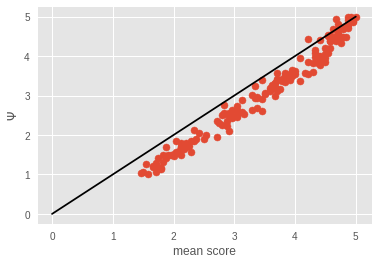

In [0]:
plt.scatter(np.mean(o_val,axis=1),psi)
plt.plot([0,5],[0,5],'k')
plt.xlabel('mean score')
plt.ylabel(r'$\Psi$');

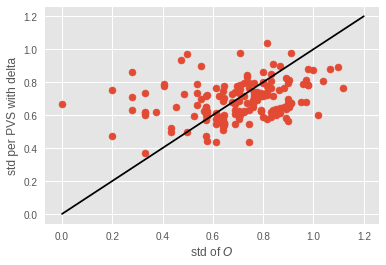

In [0]:
plt.scatter(np.std(o_val,axis=1),a)
plt.plot([0,1.2],[0,1.2],'k')
plt.xlabel('std of $O$')
plt.ylabel(r'std per PVS with delta');

Let us now use the generative code for inference with  $b$,  $c$ and variance $a_v^4$ as variables

* Distribution of $O_{ij}$ is quantized normal implemeted using  ```tfp.edward2```
* MLE is obtained by minimizing negative log_prob.
* Initial condition from moments estimators

In [0]:
g = tf.Graph()
with g.as_default():
    
    b = tf.Variable(np.random.normal(loc=0.0,scale=0.3,size=(1,nSub)).astype(np.float32))
    #c = tf.Variable(np.random.normal(loc=3.0,scale=3/2,size=(nPVS,1)).astype(np.float32))
    c = tf.Variable(np.expand_dims(np.mean(o_val,axis=1),axis=1))

    loc = b +c
    #parametryzacja kwadratem gwarantuje dodatnie std
    
    #av = tf.Variable(np.sqrt(np.expand_dims(np.std(o_val,axis=1),axis=1)) )**2
    #av = tf.Variable(np.random.normal(loc=0.0,scale=0.6,size=(nPVS,1)).astype(np.float32) )**2
    
    av = tf.Variable(np.random.normal(loc=0.0,scale=0.01,size=(nPVS,1)).astype(np.float32)+
                    np.sqrt(np.expand_dims(np.std(o_val,axis=1),axis=1)))**2
    
    o = tfp.edward2.Normal(loc=loc,scale=av)
    o = tfp.edward2.QuantizedDistribution(o.distribution, low=np.float32(1.0), high=np.float32(5.0))
    loss = tf.reduce_mean(o.distribution.log_prob(o_val))

    #gs=tf.contrib.training.get_or_create_eval_step()
    #lr = tf.train.exponential_decay(0.1,gs,decay_steps=100,decay_rate=0.9999)
    #train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(-loss, global_step=gs)
    
    # to jest bardzo dobre
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.0005).minimize(-loss)


with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(3000):
        _,np_loss = sess.run([train_op,loss])
        if i % 500 ==0:
            print(i,np_loss)
    b_val,c_val, av_val,loss_val = sess.run([b,c,av,loss])


0 -1.260689
500 -1.010588
1000 -0.911484
1500 -0.88575566
2000 -0.87888974
2500 -0.87868965


Text(0.5,0,'Recovered score')

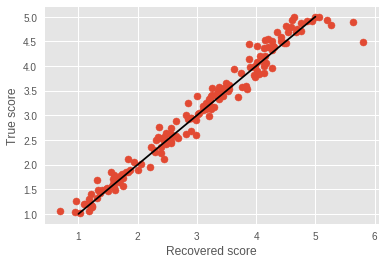

In [0]:
plt.scatter(c_val,psi)
plt.plot([1,5],[1,5],'k')
plt.ylabel('True score')
plt.xlabel('Recovered score')

Text(0.5,0,'Recovered bias')

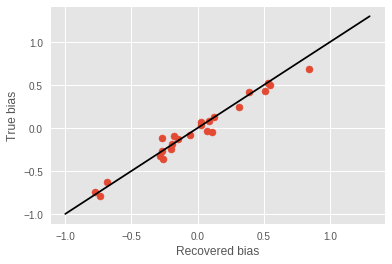

In [0]:
plt.scatter(b_val,Delta)
plt.plot([-1,1.3],[-1,1.3],'k')
plt.ylabel('True bias')
plt.xlabel('Recovered bias')

Text(0.5,0,'Recovered std')

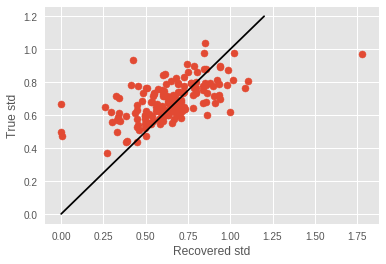

In [0]:
plt.scatter(av_val,a)
plt.plot([0,1.2],[0,1.2],'k')
plt.ylabel('True std')
plt.xlabel('Recovered std')

# Gradients (Work in progress)

For some points obtaines from momments estimator, numerical procedures are unstable and nan accure




In [0]:
o64 = o_val.astype(np.float64)
g = tf.Graph()
with g.as_default():

    b = tf.Variable(np.random.normal(loc=0.0,scale=0.3,size=(1,nSub)).astype(np.float64))
    c = tf.Variable(np.expand_dims(np.mean(o64,axis=1),axis=1))

    loc = b +c
    #parametryzacja kwadratem gwarantuje dodatnie std
    
    av = tf.Variable(np.sqrt(np.expand_dims(np.std(o64,axis=1),axis=1)) )**2
    o = tfp.edward2.Normal(loc=loc,scale=av)
    o = tfp.edward2.QuantizedDistribution(o.distribution, low=np.float64(1), high=np.float64(5))

    loss = tf.reduce_mean(o.distribution.log_prob(o64))
    grad = tf.gradients(loss,[b,c,av])


with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    loss_val, grad_val = sess.run([ loss, grad])
print(loss_val,grad_val)
